# Image Classification - Handwritten Digits

We are going to use the MNIST Handwritten Digits Database as our training dataset.

In [1]:
#our dataset is present in the torchvision package
import torch
import torchvision
from torchvision.datasets import MNIST

In [2]:
#downloading the training dataset
dataset=MNIST(root='data/',download=True)

In [3]:
#the data is downloaded to the data/ directory next to the notebook and creates a pytorch dataset
len(dataset)

60000

For training the dataset contains 60,000 images but it also has an additional 10,000 for testing. Let us create the testing dataset.

In [4]:
test_dataset=MNIST(root='data/',train=False)
len(test_dataset)

10000

Let us look at a sample element from training dataset.

In [5]:
dataset[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x7FD5426AF6D0>, 5)

This is a pair consisting of 28x28 pixels image and a label. The image is an object of the class PIL.Image.Image which is a part of the imaging library Pillow. We can view image using matplotlib.

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
#previous statement indicates that we want to plot the graphs within notebook not popup

Label:  5


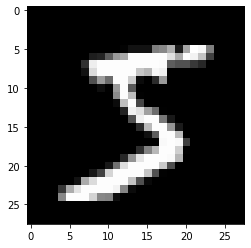

In [7]:
image,label=dataset[0]
plt.imshow(image,cmap='gray')
print('Label: ',label)

Label:  3


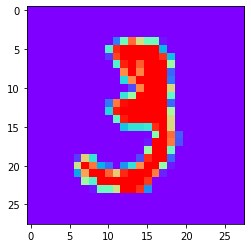

In [8]:
image,label=dataset[10]
plt.imshow(image,cmap='rainbow')
print('Label: ',label)

PyTorch does not work with images but with tensors. So we must convert our images to tensors using transforms.

In [9]:
import torchvision.transforms as transforms

In [10]:
dataset=MNIST(root='data/',
             train=True,
             transform=transforms.ToTensor())

In [11]:
img_tensor,label=dataset[0]
print(img_tensor.shape,label)

torch.Size([1, 28, 28]) 5


So now the image is converted to a 1x28x28 tensor.
   - The first dimernsion tracks color channels (grayscale=>1channel, color=>3channels(RGB))
   - The second represent pixels along height
   - The third represents pixels along width

In [12]:
print(img_tensor[0,10:15,10:15])
print(torch.max(img_tensor),torch.min(img_tensor))

tensor([[0.0039, 0.6039, 0.9922, 0.3529, 0.0000],
        [0.0000, 0.5451, 0.9922, 0.7451, 0.0078],
        [0.0000, 0.0431, 0.7451, 0.9922, 0.2745],
        [0.0000, 0.0000, 0.1373, 0.9451, 0.8824],
        [0.0000, 0.0000, 0.0000, 0.3176, 0.9412]])
tensor(1.) tensor(0.)


Values range from 0 to 1. 0 representing black and 1 for white. Values for in between shades of grey. We can plot this tensor as an image using plt.imshow

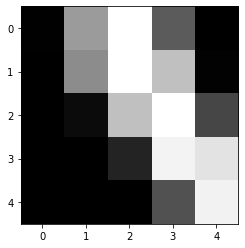

In [13]:
plt.imshow(img_tensor[0,10:15,10:15],cmap='gray')

###  Training and Validation Datasets

We split datasets into three parts commonly:

    1. Training set to train the model and compute loss and adjust weights using gradient descent.
    2. Validation set to evaluate the model during training and adjust hyperparameters such as learning rate and pick best version of model.
    3. Testing set to compare different models and report model's final accuracy.

In MNIST dataset, there are 60,000 training and 10,000 test images. Since there is no validation set, we must manually split the 60,000 images from training into 50,000 training and 10,000 validation images. We can use the random_split method.

In [14]:
from torch.utils.data import random_split
train_ds,val_ds=random_split(dataset,[50000,10000])
len(train_ds),len(val_ds)

(50000, 10000)

Important to create validation set randomly as training data is often sorted by target labels.

Now we will create data loaders to help us load data in batches. We will use batch size of 128

In [15]:
from torch.utils.data import DataLoader
batch_size=128

train_loader=DataLoader(train_ds,batch_size,shuffle=True)
val_loader=DataLoader(val_ds,batch_size)

shuffle=True makes sure that the batches generated in each epoch are different. It helps generalize and speeden the training. Since validation data loader is only used for evaluating, no need for shuffle.

In [16]:
import jovian

In [17]:
jovian.commit(project='mnist-logistic-regression')

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "nehamalcom/mnist-logistic-regression" on https://jovian.ai/
[jovian] Uploading notebook..
[jovian] Capturing environment..
[jovian] Committed successfully! https://jovian.ai/nehamalcom/mnist-logistic-regression


'https://jovian.ai/nehamalcom/mnist-logistic-regression'

### Model

We are going to use a Logistic Regression Model which is similar to a linear regression model. It contains weights and biases and the output is obtained using matrix operations pred = x @ w.t() + b

We can use nn.Linear to create the model. As nn.Linear expects each training samples to be a vector, the 1x28x28 image tensor is flattened to a vector of size 784 (28x28) before being passed into the model.

The output is a vectpr of size 10 with each element signifying the probability of a particular target label i.e. from 0 to 9. The predicted label will be the one with the highest probability.

In [18]:
import torch.nn as nn
input_size=28*28
num_classes=10

#logistic regression model
model=nn.Linear(input_size,num_classes)

In [19]:
print(model.weight.shape)
model.weight

torch.Size([10, 784])


Parameter containing:
tensor([[ 0.0348,  0.0160,  0.0145,  ...,  0.0045, -0.0025,  0.0056],
        [-0.0135, -0.0136, -0.0357,  ...,  0.0012,  0.0124,  0.0248],
        [ 0.0091,  0.0197,  0.0152,  ..., -0.0247, -0.0289,  0.0173],
        ...,
        [ 0.0328, -0.0094, -0.0196,  ..., -0.0236, -0.0237, -0.0125],
        [ 0.0134,  0.0147, -0.0105,  ..., -0.0214, -0.0091, -0.0132],
        [ 0.0058,  0.0226,  0.0042,  ...,  0.0059, -0.0190, -0.0164]],
       requires_grad=True)

In [20]:
print(model.bias.shape)
model.bias

torch.Size([10])


Parameter containing:
tensor([-0.0066,  0.0085,  0.0227,  0.0287,  0.0203, -0.0211, -0.0316, -0.0282,
         0.0281,  0.0354], requires_grad=True)

There's aroun 785 parameters here. Let's try and generate outputs using our model. We will take the first batch of 100 images from the dataset and pass them into the model.

In [21]:
for images,labels in train_loader:
    print(labels)
    print(images.shape)
    outputs=model(images)
    print(outputs)
    break

tensor([0, 3, 0, 1, 9, 4, 2, 3, 8, 1, 8, 0, 9, 8, 1, 4, 7, 8, 5, 7, 0, 0, 8, 8,
        7, 9, 0, 2, 0, 6, 9, 8, 3, 9, 0, 9, 9, 3, 7, 2, 6, 0, 8, 7, 5, 3, 6, 0,
        3, 6, 8, 5, 8, 0, 1, 7, 4, 2, 1, 6, 4, 8, 6, 5, 4, 2, 5, 0, 1, 2, 1, 5,
        9, 7, 7, 9, 6, 1, 6, 6, 9, 5, 4, 7, 0, 0, 3, 1, 0, 2, 7, 3, 0, 6, 0, 4,
        9, 9, 6, 6, 3, 5, 0, 4, 1, 1, 2, 8, 4, 4, 0, 4, 9, 1, 6, 5, 9, 2, 7, 8,
        2, 0, 1, 4, 1, 9, 2, 4])
torch.Size([128, 1, 28, 28])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (3584x28 and 784x10)

The above error is because we have not flattened our 1x28x28 to 28x28 vector yet.

In [22]:
images.shape

torch.Size([128, 1, 28, 28])

In [23]:
images.reshape(128,784).shape

torch.Size([128, 784])

The .reshape method of a tensor efficiently lets us 'view' each image as a flat vector without creating a copy of the underlying data. Let's extend the nn.Module class from PyTorch to define a custom model.

In [24]:
class MnistModel(nn.Module):
        def __init__(self):
            super().__init__()
            self.linear=nn.Linear(input_size,num_classes)
        def forward(self,xb):
            xb=xb.reshape(-1,784)
            out=self.linear(xb)
            return out

model=MnistModel()

Understanding the class MnistModel(nn.Module)

-in init constructor: instantiate weights and biases using nn.Linear

-in forward method: invoked when batch of inputs passed to model, input tensor is flattened and passed to self-linear

-xb.reshape indicates to PyTorch that we want a view of xb tensor with 2 dimensions

in xb.reshape we gave 01 to let PyTorch figure out automatically based on shape of original tensor.

In [25]:
model.linear

Linear(in_features=784, out_features=10, bias=True)

In [26]:
print(model.linear.weight.shape,model.linear.bias.shape)
list(model.parameters())

torch.Size([10, 784]) torch.Size([10])


[Parameter containing:
 tensor([[ 0.0250, -0.0280,  0.0297,  ..., -0.0126,  0.0101, -0.0152],
         [-0.0167, -0.0238, -0.0204,  ...,  0.0274,  0.0123, -0.0107],
         [-0.0224,  0.0131,  0.0069,  ...,  0.0076, -0.0315,  0.0136],
         ...,
         [ 0.0304, -0.0294, -0.0185,  ..., -0.0281, -0.0110,  0.0326],
         [-0.0322,  0.0328,  0.0218,  ..., -0.0195,  0.0208,  0.0115],
         [-0.0294,  0.0267,  0.0228,  ..., -0.0045, -0.0300,  0.0037]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.0268, -0.0108, -0.0017, -0.0041,  0.0015,  0.0062,  0.0103,  0.0352,
          0.0275, -0.0036], requires_grad=True)]

In [27]:
for images,labels in train_loader:
    print(images.shape)
    outputs=model(images)
    break
    
print('outputs.shape:',outputs.shape)
print('Sample outputs:\n',outputs[:2].data)

torch.Size([128, 1, 28, 28])
outputs.shape: torch.Size([128, 10])
Sample outputs:
 tensor([[ 0.2912,  0.0287,  0.0643, -0.1243,  0.0335, -0.1205, -0.0895, -0.2215,
          0.1661, -0.0344],
        [ 0.4564, -0.2161, -0.1777, -0.0116, -0.1473, -0.0706, -0.1632, -0.2098,
          0.1352,  0.1626]])


For each of the 100 input images, we are getting 10 outputs one for each class (number). Because we want them to represent probabilities, each output row's elements must be between 0 to 1 and add up to 1. 

This is not what happens here. So to convert these outputs to probabilities, we use softmax function.

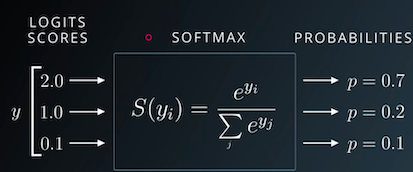

So here are the steps to use softmax function:

    1. Replace each element yi by e^yi
    2. Divide them by their sum
   
This implementation is built in PyTorch

In [28]:
import torch.nn.functional as F

In [29]:
outputs[:2]

tensor([[ 0.2912,  0.0287,  0.0643, -0.1243,  0.0335, -0.1205, -0.0895, -0.2215,
          0.1661, -0.0344],
        [ 0.4564, -0.2161, -0.1777, -0.0116, -0.1473, -0.0706, -0.1632, -0.2098,
          0.1352,  0.1626]], grad_fn=<SliceBackward>)

In [32]:
#softmax for each output row
probs=F.softmax(outputs,dim=1)

#looking at sample probabilities
print("Sample probabilities:\n",probs[:2].data)

#add up probabilities
print("Sum: ",torch.sum(probs[0]).item())

Sample probabilities:
 tensor([[0.1325, 0.1019, 0.1056, 0.0874, 0.1024, 0.0878, 0.0905, 0.0793, 0.1169,
         0.0957],
        [0.1581, 0.0807, 0.0838, 0.0990, 0.0864, 0.0933, 0.0851, 0.0812, 0.1146,
         0.1178]])
Sum:  1.0


So to predict the final label, we can take the element index of highest element. We can use torch.max for this.

In [33]:
max_probs,preds=torch.max(probs,dim=1)
print(preds)
print(max_probs)

tensor([0, 0, 3, 0, 3, 2, 0, 7, 7, 0, 7, 3, 0, 0, 9, 9, 0, 0, 2, 0, 6, 2, 0, 0,
        0, 3, 3, 7, 3, 0, 3, 0, 2, 0, 0, 9, 0, 0, 0, 9, 2, 2, 7, 0, 0, 2, 3, 0,
        0, 0, 3, 2, 0, 0, 2, 0, 0, 3, 0, 0, 9, 0, 2, 0, 0, 9, 6, 3, 9, 2, 6, 8,
        6, 0, 8, 0, 3, 9, 0, 0, 0, 7, 7, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 3, 2, 9,
        0, 9, 0, 7, 2, 0, 0, 0, 3, 3, 0, 0, 2, 9, 3, 0, 4, 9, 2, 2, 9, 3, 6, 0,
        2, 6, 0, 8, 9, 6, 3, 9])
tensor([0.1325, 0.1581, 0.1238, 0.1461, 0.1483, 0.1297, 0.1194, 0.1233, 0.1135,
        0.1450, 0.1249, 0.1369, 0.1311, 0.1258, 0.1559, 0.1608, 0.1337, 0.1150,
        0.1356, 0.1112, 0.1159, 0.1178, 0.1214, 0.1820, 0.1442, 0.1275, 0.1279,
        0.1318, 0.1316, 0.1307, 0.1293, 0.1214, 0.1160, 0.1445, 0.1274, 0.1307,
        0.1341, 0.1167, 0.1286, 0.1235, 0.1467, 0.1179, 0.1121, 0.1125, 0.1814,
        0.1252, 0.1434, 0.1191, 0.1145, 0.1422, 0.1203, 0.1190, 0.1184, 0.1340,
        0.1155, 0.1130, 0.1561, 0.1260, 0.1568, 0.1203, 0.1325, 0.1175, 0.1200,
       

Let's compare with actual labels.

In [34]:
labels

tensor([9, 3, 9, 2, 6, 7, 4, 9, 7, 2, 6, 0, 8, 5, 6, 4, 4, 3, 4, 8, 7, 6, 1, 2,
        0, 7, 9, 5, 8, 5, 5, 1, 6, 2, 9, 3, 2, 1, 5, 1, 7, 6, 7, 5, 8, 6, 4, 1,
        9, 3, 9, 1, 3, 9, 9, 1, 3, 7, 5, 2, 2, 3, 3, 8, 1, 7, 5, 4, 2, 4, 4, 3,
        4, 2, 1, 0, 7, 2, 3, 4, 2, 8, 0, 7, 2, 5, 9, 2, 4, 0, 5, 0, 6, 0, 9, 6,
        9, 6, 9, 4, 9, 9, 0, 1, 6, 6, 5, 1, 7, 1, 0, 5, 7, 1, 4, 6, 6, 8, 4, 9,
        8, 4, 2, 1, 1, 9, 9, 0])

Most of it is predicted wrong, that is because we haven't trained our model yet

## Evaluation Metric and Loss Function

Let's determine accuracy of the predicted labels.

In [35]:
outputs[:2]


tensor([[ 0.2912,  0.0287,  0.0643, -0.1243,  0.0335, -0.1205, -0.0895, -0.2215,
          0.1661, -0.0344],
        [ 0.4564, -0.2161, -0.1777, -0.0116, -0.1473, -0.0706, -0.1632, -0.2098,
          0.1352,  0.1626]], grad_fn=<SliceBackward>)

In [36]:
torch.sum(preds==labels)

tensor(6)

==compares element wise two tensors of same shape and returns True for unequal elements and False for equal elements and torch.sum returns number of labels predicted correctly.

We divide by total number of images to get accuracy

In [40]:
def accuracy(outputs,labels):
    _,preds=torch.max(outputs,dim=1)
    return torch.tensor(torch.sum(preds==labels).item()/len(preds))

In [41]:
accuracy(outputs,labels)

tensor(0.0469)

In [42]:
probs

tensor([[0.1325, 0.1019, 0.1056,  ..., 0.0793, 0.1169, 0.0957],
        [0.1581, 0.0807, 0.0838,  ..., 0.0812, 0.1146, 0.1178],
        [0.1088, 0.0875, 0.1090,  ..., 0.0906, 0.1019, 0.1102],
        ...,
        [0.1127, 0.0968, 0.1139,  ..., 0.0896, 0.0905, 0.0867],
        [0.1031, 0.0707, 0.1160,  ..., 0.0924, 0.0898, 0.1045],
        [0.1097, 0.1025, 0.0938,  ..., 0.1305, 0.0958, 0.1316]],
       grad_fn=<SoftmaxBackward>)

We cannot use accuracy as a loss function to optimize our model using gradient descent, why? Because:
    
    1. It is not a differentiable function (both torch.max and ==)
    2. It does not take into account the actual probabilities by the model so it cannot provide needed feedback for incremental imporvements in gradient descent.

Thus, accuracy is used as an evaluation metric but not as a loss function.

Cross-entropy is a commonly used loss function.

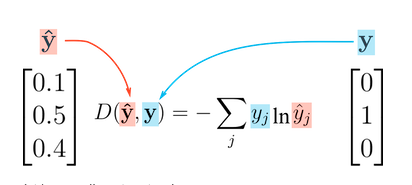

The steps are:

    1. For each output row, take the predicted probability for the correct label
    2. Take log of the picked probability, if it is high (close to 1) then log will be a very small negative value close to 0. If it is low (close to 0) then log is a very large negative value. We can multiply this log value by -1 to make it positive.
    3. Take average of the cross entropy across all output rows to get overall loss for a batch of data.

Cross-entropy is a continuous and non-differentiable function. An implementation of cross-entropy is found in torch.nn.functional package. Also it performs softmax internally so we can directly pass the model outputs without converting them into probabilities.

In [43]:
outputs


tensor([[ 0.2912,  0.0287,  0.0643,  ..., -0.2215,  0.1661, -0.0344],
        [ 0.4564, -0.2161, -0.1777,  ..., -0.2098,  0.1352,  0.1626],
        [ 0.1518, -0.0664,  0.1535,  ..., -0.0306,  0.0868,  0.1647],
        ...,
        [ 0.2006,  0.0486,  0.2114,  ..., -0.0282, -0.0188, -0.0619],
        [ 0.1081, -0.2682,  0.2259,  ..., -0.0012, -0.0295,  0.1215],
        [ 0.2461,  0.1783,  0.0898,  ...,  0.4195,  0.1104,  0.4284]],
       grad_fn=<AddmmBackward>)

In [44]:
loss_fn=F.cross_entropy

In [45]:
#loss for the current data batch
loss=loss_fn(outputs,labels)
print(loss)

tensor(2.3196, grad_fn=<NllLossBackward>)


Interpreting this loss, e^-2.3196 around 0.1 is the predicted probability of the correct label on average, the lower the loss the better.

## Training the model

Pseudocode:

    for epoch in range(num_epochs):
        # Training phase
        for batch in train_loader:
            # generate predictions
            # calculate loss
            # compute gradients
            # update weights
            # reset gradients
        # Validation phase
        for batch in val_loader:
            # generate predictions
            # calculate loss
            # calculate metrics
        # calculate average validation loss and metrics
        
        # log epoch, loss and metrics for inspection

In [64]:
def fit(epochs,lr,model,train_loader,val_loader,opt_func=torch.optim.SGD):
    optimizer=opt_func(model.parameters(),lr)
    history=[] #for recording epoch-wise results
    for epoch in range(epochs):
            #training phase
            for batch in train_loader:
                loss=model.training_step(batch)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
            #validation phase
            result=evaluate(model,val_loader)
            model.epoch_end(epoch,result)
            history.append(result)
    return history

fit function records the validation loadd and metric from each epoch, returns a history of the training for debugging and visualization.

Hyperparameters like batch size, learning rate etc. need to be picked in advance while training machine learning models

In [65]:
l1=[1,2,3,4,5]
l2=[x*2 for x in l1]
l2

[2, 4, 6, 8, 10]

In [66]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [67]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear=nn.Linear(input_size,num_classes)
    
    def forward(self,xb):
        xb=xb.reshape(-1,784)
        out=self.linear(xb)
        return out
    
    def training_step(self,batch):
        images,labels=batch
        out=self(images) #generate predictions
        loss=F.cross_entropy(out,labels) #calculate loss
        return loss
    
    def validation_step(self,batch):
        images,labels=batch
        out=self(images) #generate predictions
        loss=F.cross_entropy(out,labels) #calculate loss
        acc=accuracy(out,labels) #calculate accuracy
        return {'val_loss':loss,'val_acc':acc}
    
    def validation_epoch_end(self,outputs):
        batch_losses=[x['val_loss'] for x in outputs]
        epoch_loss=torch.stack(batch_losses).mean() #combine losses
        batch_accs=[x['val_acc'] for x in outputs]
        epoch_acc=torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(),'val_acc': epoch_acc.item()}
    def epoch_end(self,epoch,result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch,result['val_loss'],result['val_acc']))
        
model=MnistModel()

In [68]:
result0=evaluate(model,val_loader)
result0

{'val_loss': 2.2963130474090576, 'val_acc': 0.11125395447015762}

Now let us train the model.

Let us take number of epochs as 5.

In [69]:
history1=fit(5,0.001,model,train_loader,val_loader)

Epoch [0], val_loss: 1.9344, val_acc: 0.6379
Epoch [1], val_loss: 1.6703, val_acc: 0.7356
Epoch [2], val_loss: 1.4723, val_acc: 0.7726
Epoch [3], val_loss: 1.3224, val_acc: 0.7862
Epoch [4], val_loss: 1.2071, val_acc: 0.7975


With just 5 epochs, we have reached accuracy of 79.69%. Let us try improving it by training for few more epochs.

In [70]:
history2=fit(5,0.001,model,train_loader,val_loader)

Epoch [0], val_loss: 1.1164, val_acc: 0.8059
Epoch [1], val_loss: 1.0436, val_acc: 0.8111
Epoch [2], val_loss: 0.9840, val_acc: 0.8170
Epoch [3], val_loss: 0.9343, val_acc: 0.8220
Epoch [4], val_loss: 0.8922, val_acc: 0.8262


In [71]:
history3=fit(5,0.001,model,train_loader,val_loader)

Epoch [0], val_loss: 0.8562, val_acc: 0.8302
Epoch [1], val_loss: 0.8250, val_acc: 0.8348
Epoch [2], val_loss: 0.7976, val_acc: 0.8383
Epoch [3], val_loss: 0.7734, val_acc: 0.8408
Epoch [4], val_loss: 0.7518, val_acc: 0.8431


In [72]:
history4=fit(5,0.001,model,train_loader,val_loader)

Epoch [0], val_loss: 0.7325, val_acc: 0.8466
Epoch [1], val_loss: 0.7150, val_acc: 0.8486
Epoch [2], val_loss: 0.6991, val_acc: 0.8503
Epoch [3], val_loss: 0.6847, val_acc: 0.8523
Epoch [4], val_loss: 0.6714, val_acc: 0.8531


One can see the accuracy keeps improving but gets smaller and smaller.

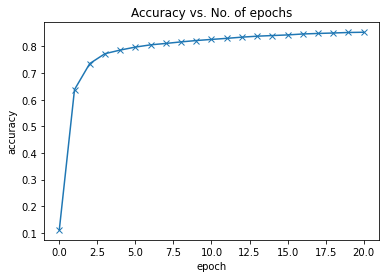

In [73]:
history=[result0]+history1+history2+history3+history4
accuracies=[result['val_acc'] for result in history]
plt.plot(accuracies,'-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

Probable reason for model not being able to reach 90% threshold is that learning rate may be too high, the model's parameters may be bouncing around the optimal set of parameters for the lowest loss. The more likely reason is that the model just isn't powerful enough, we assumed that the output is a linear function of the input (pixel intensities). It is a weak assumption.

In [74]:
jovian.log_metrics(val_acc=history[-1]['val_acc'], val_loss=history[-1]['val_loss'])

[jovian] Metrics logged.


In [75]:
jovian.commit(project='03-logistic-regression', environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Creating a new project "nehamalcom/03-logistic-regression"
[jovian] Uploading notebook..
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/nehamalcom/03-logistic-regression


'https://jovian.ai/nehamalcom/03-logistic-regression'

## Testing with individual images

Let us take the model's results on some sample images

In [76]:
#defining test dataset
test_dataset=MNIST(root='data/',train=False,transform=transforms.ToTensor())

Shape: torch.Size([1, 28, 28])
Label: 7


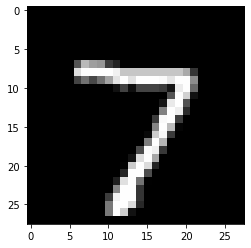

In [77]:
img,label=test_dataset[0]
plt.imshow(img[0],cmap='gray')
print('Shape:',img.shape)
print('Label:',label)

In [78]:
def predict_image(img,model):
    xb=img.unsqueeze(0)
    yb=model(xb)
    _,preds=torch.max(yb,dim=1)
    return preds[0].item()

img.unsqueeze adds another dimension at the beginning of the 1x28x28 tensor, making it a 1x1x28x28 tensor, which the model views as a batch containing a single image.

Label: 7 Predicted: 7


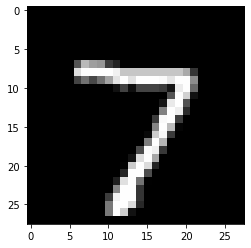

In [79]:
img,label=test_dataset[0]
plt.imshow(img[0],cmap='gray')
print('Label:',label,'Predicted:',predict_image(img,model))

Label: 1 Predicted: 1


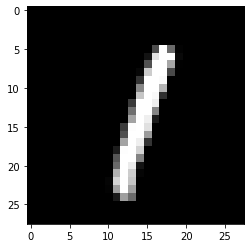

In [80]:
img,label=test_dataset[5]
plt.imshow(img[0],cmap='gray')
print('Label:',label,'Predicted:',predict_image(img,model))

Label: 9 Predicted: 9


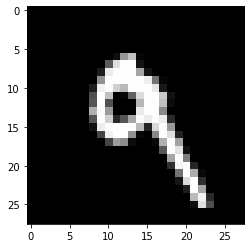

In [81]:
img,label=test_dataset[7]
plt.imshow(img[0],cmap='gray')
print('Label:',label,'Predicted:',predict_image(img,model))

Label: 6 Predicted: 6


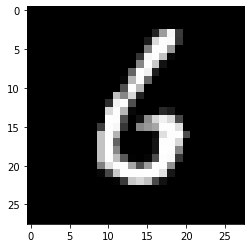

In [82]:
img,label=test_dataset[50]
plt.imshow(img[0],cmap='gray')
print('Label:',label,'Predicted:',predict_image(img,model))

Label: 9 Predicted: 9


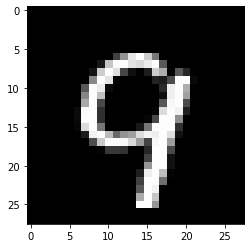

In [83]:
img,label=test_dataset[16]
plt.imshow(img[0],cmap='gray')
print('Label:',label,'Predicted:',predict_image(img,model))

Label: 6 Predicted: 2


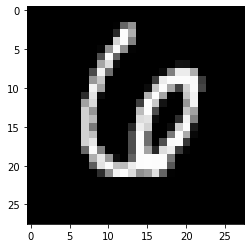

In [87]:
img,label=test_dataset[66]
plt.imshow(img[0],cmap='gray')
print('Label:',label,'Predicted:',predict_image(img,model))

Let us look at the overall loss and accuracy of the model on the test set.

In [88]:
test_loader=DataLoader(test_dataset,batch_size=256)
result=evaluate(model,test_loader)
result

{'val_loss': 0.639461874961853, 'val_acc': 0.8617187738418579}

In [89]:
torch.save(model.state_dict(), 'mnist-logistic.pth')

In [91]:
model.state_dict()

OrderedDict([('linear.weight',
              tensor([[-0.0088, -0.0215,  0.0066,  ..., -0.0187, -0.0019, -0.0102],
                      [ 0.0319,  0.0161, -0.0253,  ...,  0.0189, -0.0121, -0.0266],
                      [ 0.0245,  0.0161, -0.0344,  ...,  0.0342,  0.0117,  0.0063],
                      ...,
                      [ 0.0266, -0.0066,  0.0080,  ...,  0.0146, -0.0211, -0.0272],
                      [-0.0019, -0.0028,  0.0325,  ..., -0.0016,  0.0344,  0.0083],
                      [-0.0227, -0.0075,  0.0103,  ..., -0.0108,  0.0301, -0.0142]])),
             ('linear.bias',
              tensor([-0.0446,  0.0848, -0.0326, -0.0092,  0.0242,  0.0746, -0.0065,  0.0697,
                      -0.1108, -0.0188]))])

The .state_dict method returns an OrderedDict containing all the weights and bias matrices mapped to the right attributes of the model.

In [92]:
model2 = MnistModel()

In [93]:
model2.state_dict()

OrderedDict([('linear.weight',
              tensor([[ 2.0796e-02, -1.3062e-02, -2.9040e-02,  ...,  2.7333e-02,
                        3.5695e-02, -1.2552e-02],
                      [-1.3484e-02,  2.8197e-02, -3.4194e-02,  ...,  1.7936e-02,
                       -9.4047e-03,  2.4176e-02],
                      [ 1.1243e-02, -1.9815e-02, -2.0001e-02,  ...,  2.0671e-02,
                        2.2972e-02, -2.9805e-02],
                      ...,
                      [-1.1693e-02, -1.7406e-02,  1.4412e-02,  ..., -1.8358e-02,
                       -2.0830e-02,  1.6886e-02],
                      [-1.1465e-02,  5.5096e-04, -1.6796e-02,  ..., -2.5653e-03,
                       -3.0643e-02,  3.2706e-02],
                      [-2.6573e-03,  7.1038e-03, -2.7133e-02,  ..., -1.5177e-02,
                       -4.1503e-05, -1.4205e-02]])),
             ('linear.bias',
              tensor([ 0.0323,  0.0354, -0.0158,  0.0302, -0.0107,  0.0349,  0.0010, -0.0282,
                      -0.0191,

In [94]:
evaluate(model2, test_loader)

{'val_loss': 2.3114991188049316, 'val_acc': 0.08320312201976776}

In [95]:
model2.load_state_dict(torch.load('mnist-logistic.pth'))
model2.state_dict()

OrderedDict([('linear.weight',
              tensor([[-0.0088, -0.0215,  0.0066,  ..., -0.0187, -0.0019, -0.0102],
                      [ 0.0319,  0.0161, -0.0253,  ...,  0.0189, -0.0121, -0.0266],
                      [ 0.0245,  0.0161, -0.0344,  ...,  0.0342,  0.0117,  0.0063],
                      ...,
                      [ 0.0266, -0.0066,  0.0080,  ...,  0.0146, -0.0211, -0.0272],
                      [-0.0019, -0.0028,  0.0325,  ..., -0.0016,  0.0344,  0.0083],
                      [-0.0227, -0.0075,  0.0103,  ..., -0.0108,  0.0301, -0.0142]])),
             ('linear.bias',
              tensor([-0.0446,  0.0848, -0.0326, -0.0092,  0.0242,  0.0746, -0.0065,  0.0697,
                      -0.1108, -0.0188]))])

In [96]:
test_loader = DataLoader(test_dataset, batch_size=256)
result = evaluate(model2, test_loader)
result

{'val_loss': 0.639461874961853, 'val_acc': 0.8617187738418579}

In [97]:
jovian.commit(project='03-logistic-regression', environment=None, outputs=['mnist-logistic.pth'])

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "nehamalcom/03-logistic-regression" on https://jovian.ai/
[jovian] Uploading notebook..
[jovian] Uploading additional outputs...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/nehamalcom/03-logistic-regression


'https://jovian.ai/nehamalcom/03-logistic-regression'